# CTS Stock Price Predict using GARCH (7:3)

Import thư viện cần thiết

In [43]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

Import data và chuyển về dạng float

In [44]:
# Đọc dữ liệu từ tệp CSV và đảm bảo rằng cột 'Date' được chuyển đổi đúng cách
df_CTS = pd.read_csv('../Dataset/DataCTS.csv', usecols=['Date', 'Price'], index_col='Date', parse_dates=True, dayfirst=True)

# Đảm bảo rằng index là dạng datetime
df_CTS.index = pd.to_datetime(df_CTS.index, dayfirst=True)

In [45]:
df_CTS.head()

,Price
Date,
2019-01-02,6504.1
2019-01-03,6385.6
2019-01-04,6240.7
2019-01-05,6240.7
2019-01-06,6240.7


In [46]:
print(df_CTS.dtypes)


Price    float64
dtype: object


In [47]:
# Loại bỏ dấu phẩy từ các cột số
numeric_cols_CTS = ['Price']
df_CTS[numeric_cols_CTS] = df_CTS[numeric_cols_CTS].replace(',', '', regex=True)

# Chuyển đổi các cột sang kiểu float
df_CTS[numeric_cols_CTS] = df_CTS[numeric_cols_CTS].astype(float)

# Hiển thị DataFrame đã chuyển đổi
print(df_CTS)
df_CTS.describe()

              Price
Date               
2019-01-02   6504.1
2019-01-03   6385.6
2019-01-04   6240.7
2019-01-05   6240.7
2019-01-06   6240.7
...             ...
2024-05-28  43850.0
2024-05-29  42850.0
2024-05-30  43500.0
2024-05-31  42500.0
2024-06-01  42500.0

[1978 rows x 1 columns]


,Price
count,1978.000000
mean,15460.873559
std,9915.230695
min,3830.700000
25%,6076.200000
50%,13358.100000
75%,22358.100000
max,43850.000000


Trực quan hóa dữ liệu

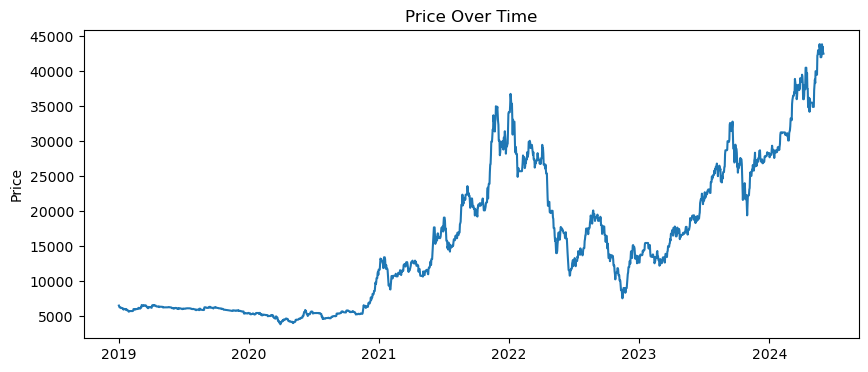

In [48]:
# Assuming you have a DataFrame 'df' with a 'Price' column
plt.figure(figsize=(10, 4))
plt.plot(df_CTS['Price'])
plt.title('Price Over Time')
plt.ylabel('Price')
plt.show()

Tính tỉ lệ % thay đổi (volatily) giữa các hàng dữ liệu

In [49]:
volatily_CTS = 100 * df_CTS.Price.pct_change().dropna()

Trực quan hóa tỉ lệ % biến động

Text(0.5, 1.0, 'Volatily')

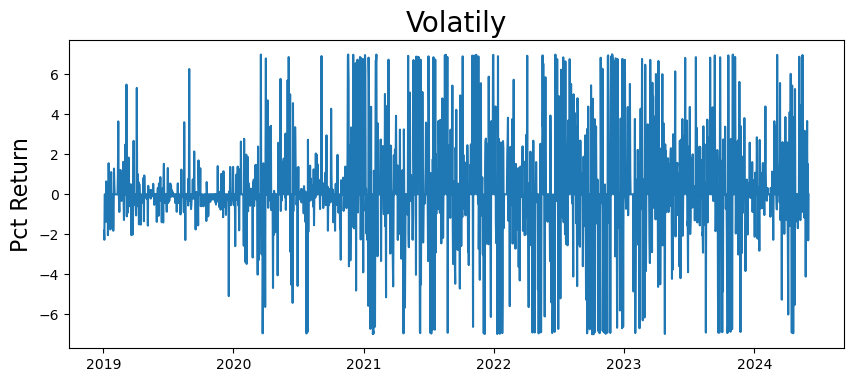

In [50]:
plt.figure(figsize=(10,4))
plt.plot(volatily_CTS)
plt.ylabel('Pct Return', fontsize=16)
plt.title('Volatily', fontsize=20)

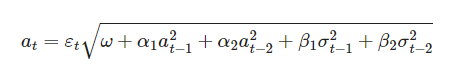

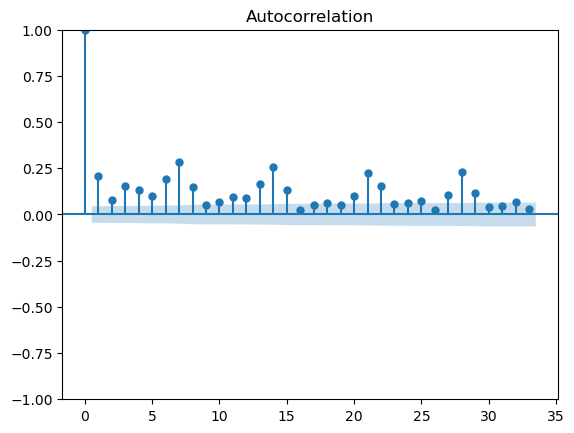

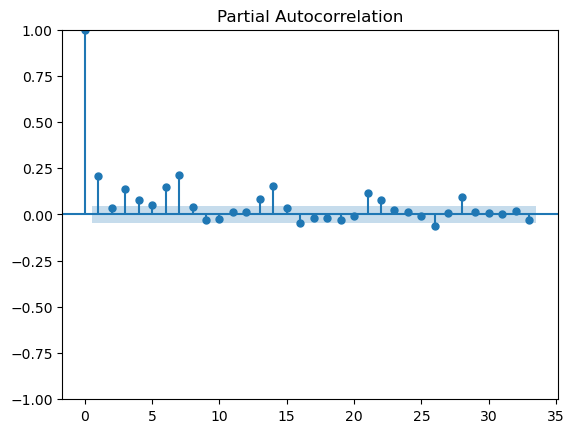

In [51]:
plot_acf(volatily_CTS**2)
plot_pacf(volatily_CTS**2)
plt.show()

Fit model

In [52]:
model = arch_model(volatily_CTS, p=1, q=1)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1062464.9683719103
Iteration:      2,   Func. Count:     14,   Neg. LLF: 6970.4759281567085
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4416.641538209416
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4411.845112968667
Iteration:      5,   Func. Count:     32,   Neg. LLF: 4432.207604534236
Iteration:      6,   Func. Count:     38,   Neg. LLF: 4415.514185368422
Iteration:      7,   Func. Count:     44,   Neg. LLF: 4418.8607132922425
Iteration:      8,   Func. Count:     50,   Neg. LLF: 4375.242385696662
Iteration:      9,   Func. Count:     55,   Neg. LLF: 4375.7729341036265
Iteration:     10,   Func. Count:     61,   Neg. LLF: 7848.583581887542
Iteration:     11,   Func. Count:     68,   Neg. LLF: 4386.035639641818
Iteration:     12,   Func. Count:     75,   Neg. LLF: 4373.429271921098
Iteration:     13,   Func. Count:     80,   Neg. LLF: 4373.360163115308
Iteration:     14,   Func. Count:     85,   Neg. LLF: 4373.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4373.35
Distribution:                  Normal   AIC:                           8754.71
Method:            Maximum Likelihood   BIC:                           8777.07
                                        No. Observations:                 1977
Date:                Wed, Jun 05 2024   Df Residuals:                     1976
Time:                        23:44:39   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0381  4.001e-02      0.953      0.340 [-4.027e-02,  0.117]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0236  1.593e-02      1.484      0.138 [-7.577e-03,5.486e-02]
alpha[1]       0.0547  1.179e-02      4.637  3.529e-06  [3.157e-02,7.779e-02]
beta[1]        0.9448  1.191e-02     79.311      0.000      [  0.921,  0.968]
=============================================================================

Covariance estimator: robust
"""

Neg. LLF (Negative Log Likelihood Function) giảm dần từ 1050158.370113003 xuống còn khoảng 4198.154276569618

Iterations: số lần lặp của quá trình tối ưu hóa, 16 lần lặp


Tiến hành Train dữ liệu

In [53]:
rolling_predictions_CTS = []  # Danh sách để lưu trữ các dự đoán của mô hình
test_size_CTS = int(0.3 * len(volatily_CTS))  # Xác định kích thước của tập kiểm tra là 30% của độ dài của dữ liệu volatily_CTS

# Vòng lặp for để dự đoán trượt qua từng điểm dữ liệu trong tập kiểm tra
for i in range(test_size_CTS):
    # Tạo tập dữ liệu đào tạo bằng cách cắt từ đầu đến mỗi điểm dữ liệu trong tập kiểm tra
    train_CTS = volatily_CTS[:-(test_size_CTS-i)]
    
    # Tạo mô hình GARCH (1,1) bằng cách sử dụng dữ liệu đào tạo
    model_CTS = arch_model(train_CTS, p=1, q=1)
    
    # Ước lượng mô hình GARCH đã tạo với dữ liệu đào tạo
    model_fit_CTS = model_CTS.fit(disp='off')
    
    # Dự đoán một giai đoạn tiếp theo của biến động (volatility) bằng cách sử dụng hàm forecast() từ mô hình đã ước lượng
    pred_CTS = model_fit_CTS.forecast(horizon=1)
    
    # Thêm giá trị dự đoán cuối cùng của mỗi lượt dự đoán vào danh sách rolling_predictions_CTS
    rolling_predictions_CTS.append(np.sqrt(pred_CTS.variance.values[-1,:][0]))


In [54]:
# Tạo một Series Pandas từ danh sách rolling_predictions, với index được thiết lập là các chỉ mục cuối cùng của tập dữ liệu volatily (tập kiểm tra)
rolling_predictions_CTS = pd.Series(rolling_predictions_CTS, index=volatily_CTS.index[-test_size_CTS:])

Tiến hành dự đoán biến động trong 90 ngày tiếp theo

In [55]:
from datetime import datetime, timedelta

# Giả định volatily_CTS và test_size_CTS đã được xác định trước đó

def predict_next_days(start_date, days_to_predict, volatily_CTS, test_size_CTS):
    forecasted_next_days_CTS = []
    for i in range(days_to_predict):
        train_CTS = volatily_CTS[:-(test_size_CTS+i)]
        model_CTS = arch_model(train_CTS, p=1, q=1)
        model_fit_CTS = model_CTS.fit(disp='off')
        pred_CTS = model_fit_CTS.forecast(horizon=1)
        forecasted_next_days_CTS.append(np.sqrt(pred_CTS.variance.values[-1,:][0]))

    # Thêm một giá trị không xác định (nan) vào cuối danh sách dự đoán để đại diện cho dự đoán cuối cùng
    forecasted_next_days_CTS.append(np.nan)

    # Tạo ngày bắt đầu dự đoán bằng cách sử dụng start_date được chỉ định
    start_date = start_date

    # Tạo một danh sách chỉ mục mới cho các dự đoán tiếp theo số ngày được chỉ định
    index_forecasted_CTS = pd.date_range(start=start_date, periods=len(forecasted_next_days_CTS))

    return index_forecasted_CTS, forecasted_next_days_CTS

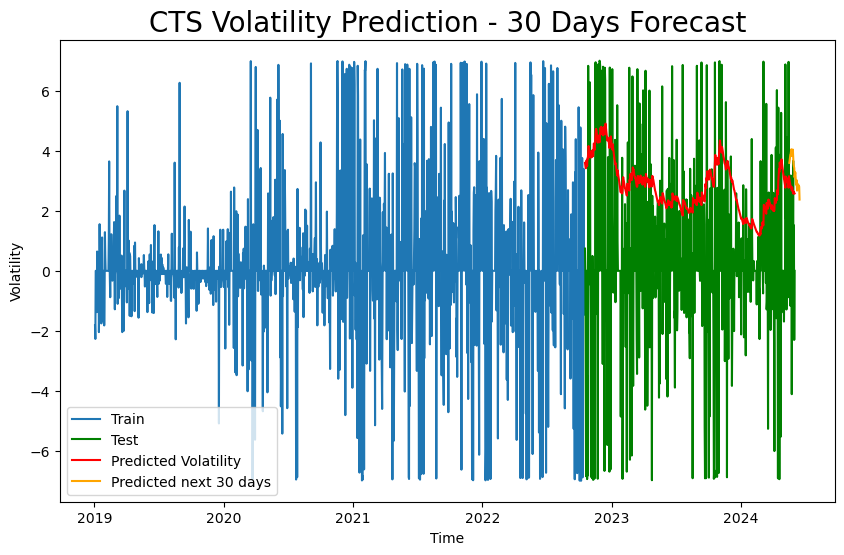

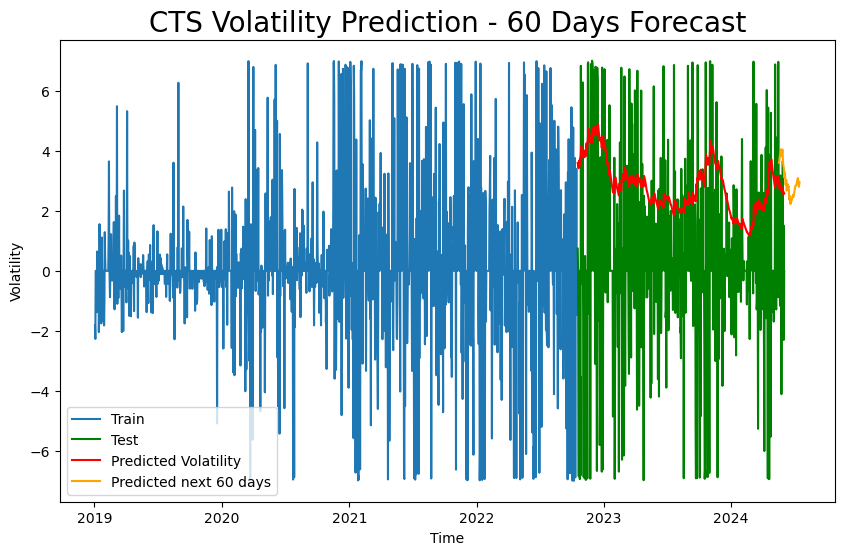

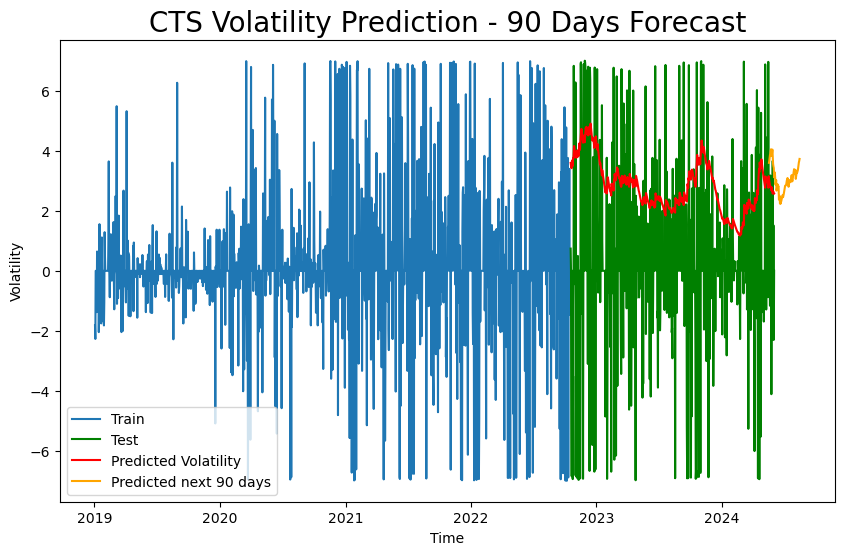

In [56]:
# Đặt số ngày dự đoán
days_to_predict = [30, 60, 90]

# Đặt ngày bắt đầu dự đoán
start_date = pd.Timestamp('2024-05-17')

# Dự đoán cho mỗi số ngày được chỉ định và vẽ biểu đồ tương ứng
for days in days_to_predict:
    index_forecasted_CTS, forecasted_next_days_CTS = predict_next_days(start_date, days, volatily_CTS, test_size_CTS)
    
    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    # Vẽ dữ liệu đào tạo
    plt.plot(volatily_CTS[:-test_size_CTS], label='Train')
    # Vẽ dữ liệu kiểm tra
    plt.plot(volatily_CTS[-test_size_CTS:], label='Test', color='green')
    # Vẽ dự đoán trượt
    plt.plot(rolling_predictions_CTS, label='Predicted Volatility', color='red')
    # Vẽ dự đoán cho số ngày được chỉ định
    plt.plot(index_forecasted_CTS, forecasted_next_days_CTS, label=f'Predicted next {days} days', color='orange')

    # Thêm tiêu đề và chú thích
    plt.title(f'CTS Volatility Prediction - {days} Days Forecast', fontsize=20)
    plt.legend(fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Volatility')

    # Hiển thị biểu đồ
    plt.show()


In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_actual_values_CTS = volatily_CTS[-test_size_CTS:]
test_predicted_values_CTS = rolling_predictions_CTS[volatily_CTS.index[-test_size_CTS:]]

# Calculate MAE_CTS (Mean Absolute Error)
mae_CTS = mean_absolute_error(test_actual_values_CTS, test_predicted_values_CTS)

# Calculate RMSE_CTS (Root Mean Squared Error)
rmse_CTS = np.sqrt(mean_squared_error(test_actual_values_CTS, test_predicted_values_CTS))

# Calculate MAPE_CTS (Mean Absolute Percentage Error)
mape_CTS = np.mean(np.abs((test_actual_values_CTS - test_predicted_values_CTS) / test_actual_values_CTS.replace(0, np.nan))) 

print("MAE_CTS:", mae_CTS)
print("RMSE_CTS:", rmse_CTS)
print("MAPE_CTS (%):", mape_CTS)


MAE_CTS: 3.1706785807166433
RMSE_CTS: 3.923114015889364
MAPE_CTS (%): 2.391702049762498


MAE = 3.39: Trung bình mỗi dự đoán có sai số khoảng 3.354 đơn vị so với giá trị thực tế.

RMSE = 4.17: Biến động trung bình của sai số là khoảng 4.145 đơn vị

MAPE = 2.38%: Trung bình mỗi dự đoán có sai số khoảng 2.411% so với giá trị thực tế.

# ACB Stock Prediction using GARCH (7:3)

In [58]:
# Đọc dữ liệu từ tệp CSV và đảm bảo rằng cột 'Date' được chuyển đổi đúng cách
df_ACB = pd.read_csv('../Dataset/DataACB.csv', usecols=['Date', 'Price'], index_col='Date', parse_dates=True, dayfirst=True)

# Đảm bảo rằng index là dạng datetime
df_ACB.index = pd.to_datetime(df_ACB.index, dayfirst=True)

In [59]:
df_ACB.head()

,Price
Date,
2019-01-02,11058.0
2019-01-03,10641.4
2019-01-04,10717.2
2019-01-05,10717.2
2019-01-06,10717.2


In [60]:
print(df_ACB.dtypes)

Price    float64
dtype: object


In [61]:
# Loại bỏ dấu phẩy từ các cột số
numeric_cols_ACB = ['Price']
df_ACB[numeric_cols_ACB] = df_ACB[numeric_cols_ACB].replace(',', '', regex=True)

# Chuyển đổi các cột sang kiểu float
df_ACB[numeric_cols_ACB] = df_ACB[numeric_cols_ACB].astype(float)

# Hiển thị DataFrame đã chuyển đổi
print(df_ACB)
df_ACB.describe()

              Price
Date               
2019-01-02  11058.0
2019-01-03  10641.4
2019-01-04  10717.2
2019-01-05  10717.2
2019-01-06  10717.2
...             ...
2024-05-28  29650.0
2024-05-29  29250.0
2024-05-30  25565.0
2024-05-31  24650.0
2024-06-01  24650.0

[1978 rows x 1 columns]


,Price
count,1978.000000
mean,19859.027907
std,6378.095584
min,8763.100000
25%,11864.600000
50%,22050.000000
75%,25272.500000
max,30360.000000


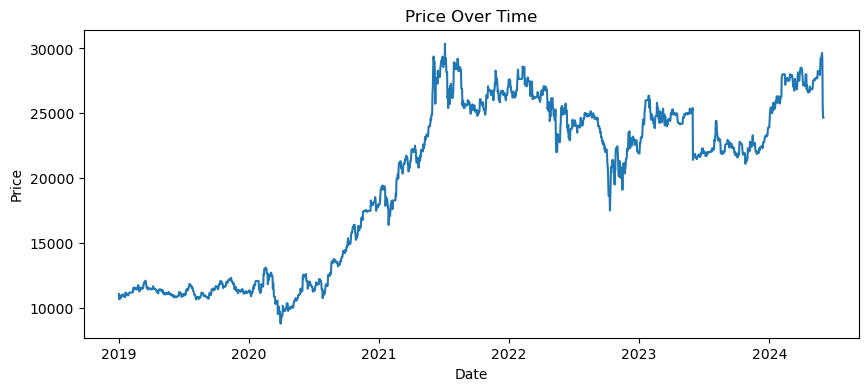

In [62]:
# Assuming you have a DataFrame 'df' with a 'Price' column
plt.figure(figsize=(10, 4))
plt.plot(df_ACB['Price'])
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [63]:
volatily_ACB = 100 * df_ACB.Price.pct_change().dropna()

Text(0.5, 1.0, 'Volatily')

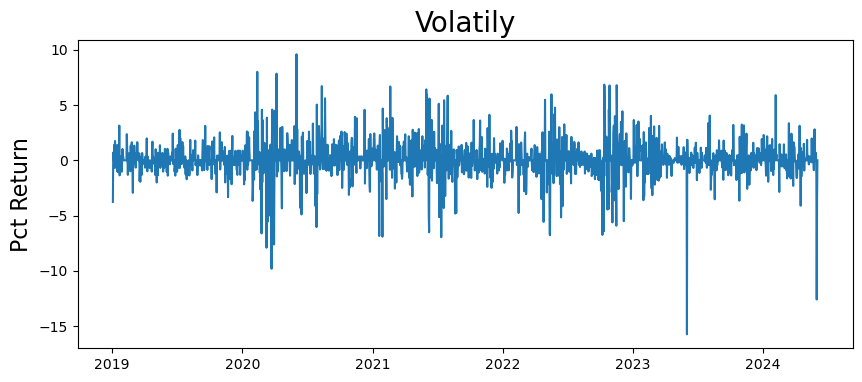

In [64]:
plt.figure(figsize=(10,4))
plt.plot(volatily_ACB)
plt.ylabel('Pct Return', fontsize=16)
plt.title('Volatily', fontsize=20)

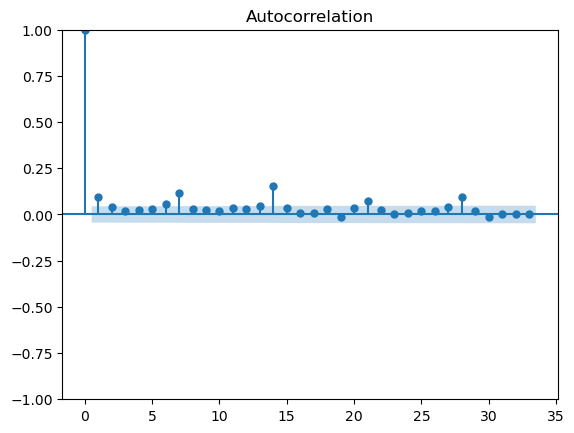

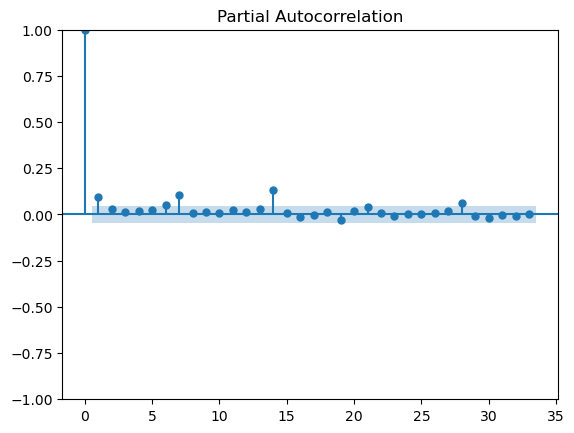

In [65]:
plot_acf(volatily_ACB**2)
plot_pacf(volatily_ACB**2)
plt.show()

In [66]:
model = arch_model(volatily_ACB, p=1, q=1)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 11539.73825117122
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3889.3821084320134
Iteration:      3,   Func. Count:     21,   Neg. LLF: 3854.160356048155
Iteration:      4,   Func. Count:     27,   Neg. LLF: 4009.283424876495
Iteration:      5,   Func. Count:     33,   Neg. LLF: 4679.864505815332
Iteration:      6,   Func. Count:     39,   Neg. LLF: 3642.2654073696563
Iteration:      7,   Func. Count:     45,   Neg. LLF: 3736.9272064041643
Iteration:      8,   Func. Count:     51,   Neg. LLF: 3590.9820156626497
Iteration:      9,   Func. Count:     57,   Neg. LLF: 3590.627254538447
Iteration:     10,   Func. Count:     62,   Neg. LLF: 3590.613080328313
Iteration:     11,   Func. Count:     67,   Neg. LLF: 3590.6123791025448
Iteration:     12,   Func. Count:     72,   Neg. LLF: 3590.612247807357
Iteration:     13,   Func. Count:     76,   Neg. LLF: 3590.612247808155
Optimization terminated successfully    (Exit mode 0)
     

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3590.61
Distribution:                  Normal   AIC:                           7189.22
Method:            Maximum Likelihood   BIC:                           7211.58
                                        No. Observations:                 1977
Date:                Wed, Jun 05 2024   Df Residuals:                     1976
Time:                        23:45:04   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0366  3.173e-02      1.152      0.249 [-2.564e-02,9.876e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1427  6.761e-02      2.111  3.480e-02   [1.019e-02,  0.275]
alpha[1]       0.0654  1.749e-02      3.739  1.851e-04 [3.110e-02,9.965e-02]
beta[1]        0.8801  2.327e-02     37.815      0.000     [  0.834,  0.926]
============================================================================

Covariance estimator: robust
"""

In [67]:
rolling_predictions_ACB = []  # Danh sách để lưu trữ các dự đoán của mô hình
test_size_ACB = int(0.3 * len(volatily_ACB))  # Xác định kích thước của tập kiểm tra là 30% của độ dài của dữ liệu volatily_ACB

# Vòng lặp for để dự đoán trượt qua từng điểm dữ liệu trong tập kiểm tra
for i in range(test_size_ACB):
    # Tạo tập dữ liệu đào tạo bằng cách cắt từ đầu đến mỗi điểm dữ liệu trong tập kiểm tra
    train_ACB = volatily_ACB[:-(test_size_ACB-i)]
    
    # Tạo mô hình GARCH (1,1) bằng cách sử dụng dữ liệu đào tạo
    model_ACB = arch_model(train_ACB, p=1, q=1)
    
    # Ước lượng mô hình GARCH đã tạo với dữ liệu đào tạo
    model_fit_ACB = model_ACB.fit(disp='off')
    
    # Dự đoán một giai đoạn tiếp theo của biến động (volatility) bằng cách sử dụng hàm forecast() từ mô hình đã ước lượng
    pred_ACB = model_fit_ACB.forecast(horizon=1)
    
    # Thêm giá trị dự đoán cuối cùng của mỗi lượt dự đoán vào danh sách rolling_predictions_ACB
    rolling_predictions_ACB.append(np.sqrt(pred_ACB.variance.values[-1,:][0]))


In [68]:
# Tạo một Series Pandas từ danh sách rolling_predictions, với index được thiết lập là các chỉ mục cuối cùng của tập dữ liệu volatily (tập kiểm tra)
rolling_predictions_ACB = pd.Series(rolling_predictions_ACB, index=volatily_ACB.index[-test_size_ACB:])

In [69]:
from datetime import datetime, timedelta

# Giả định volatily_ACB và test_size_ACB đã được xác định trước đó

def predict_next_days(start_date, days_to_predict, volatily_ACB, test_size_ACB):
    forecasted_next_days_ACB = []
    for i in range(days_to_predict):
        train_ACB = volatily_ACB[:-(test_size_ACB+i)]
        model_ACB = arch_model(train_ACB, p=1, q=1)
        model_fit_ACB = model_ACB.fit(disp='off')
        pred_ACB = model_fit_ACB.forecast(horizon=1)
        forecasted_next_days_ACB.append(np.sqrt(pred_ACB.variance.values[-1,:][0]))

    # Thêm một giá trị không xác định (nan) vào cuối danh sách dự đoán để đại diện cho dự đoán cuối cùng
    forecasted_next_days_ACB.append(np.nan)

    # Tạo ngày bắt đầu dự đoán bằng cách sử dụng start_date được chỉ định
    start_date = start_date

    # Tạo một danh sách chỉ mục mới cho các dự đoán tiếp theo số ngày được chỉ định
    index_forecasted_ACB = pd.date_range(start=start_date, periods=len(forecasted_next_days_ACB))

    return index_forecasted_ACB, forecasted_next_days_ACB

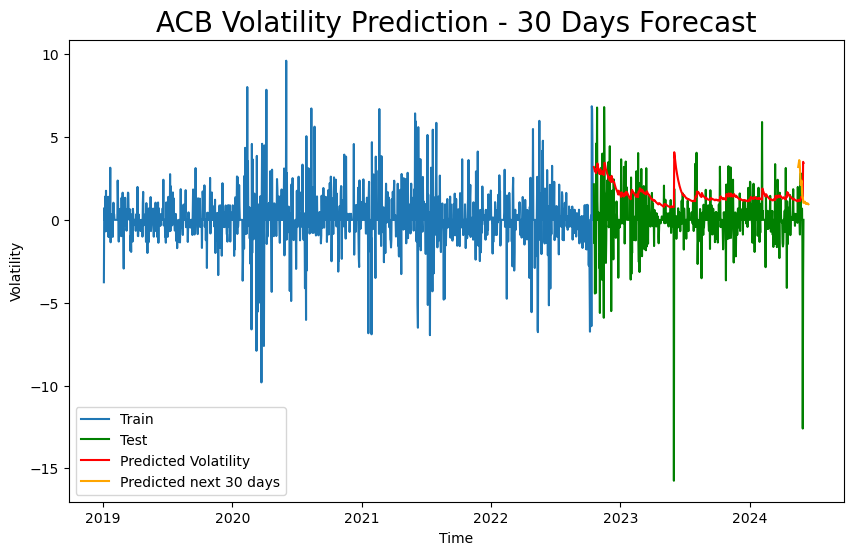

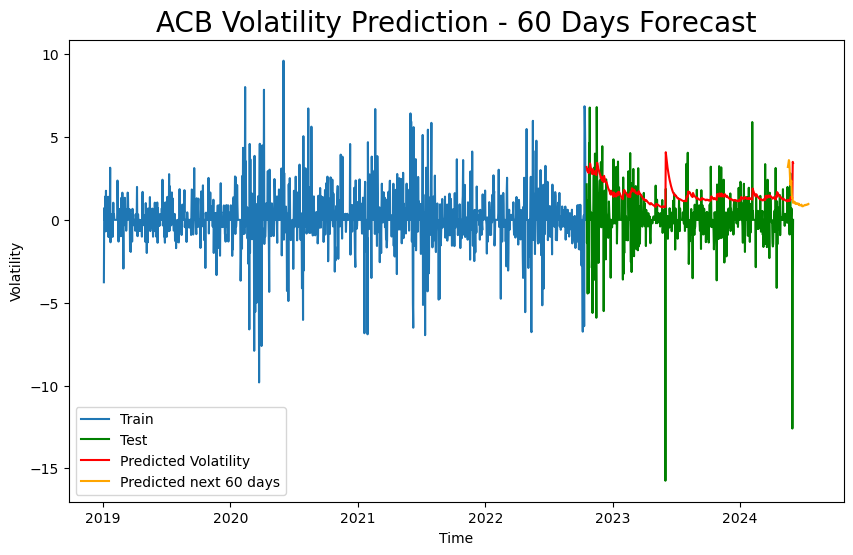

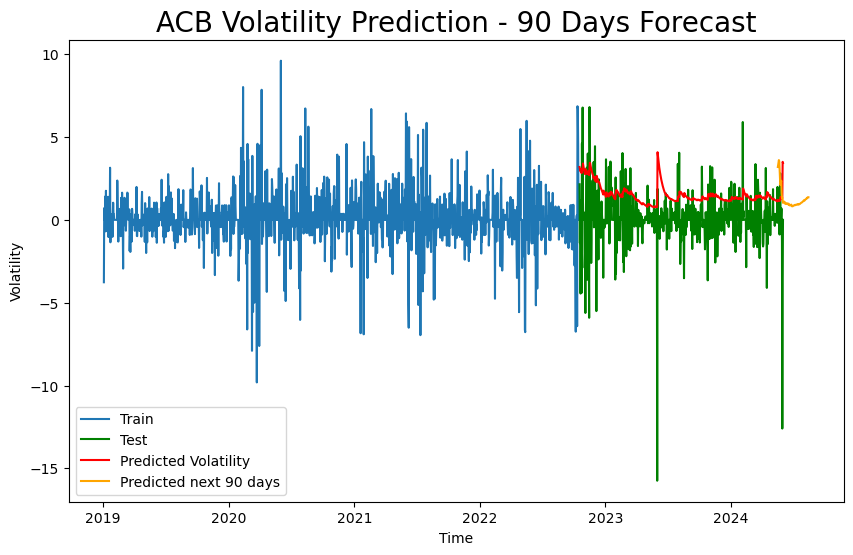

In [70]:
# Đặt số ngày dự đoán
days_to_predict = [30, 60, 90]

# Đặt ngày bắt đầu dự đoán
start_date = pd.Timestamp('2024-05-17')

# Dự đoán cho mỗi số ngày được chỉ định và vẽ biểu đồ tương ứng
for days in days_to_predict:
    index_forecasted_ACB, forecasted_next_days_ACB = predict_next_days(start_date, days, volatily_ACB, test_size_ACB)
    
    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    # Vẽ dữ liệu đào tạo
    plt.plot(volatily_ACB[:-test_size_ACB], label='Train')
    # Vẽ dữ liệu kiểm tra
    plt.plot(volatily_ACB[-test_size_ACB:], label='Test', color='green')
    # Vẽ dự đoán trượt
    plt.plot(rolling_predictions_ACB, label='Predicted Volatility', color='red')
    # Vẽ dự đoán cho số ngày được chỉ định
    plt.plot(index_forecasted_ACB, forecasted_next_days_ACB, label=f'Predicted next {days} days', color='orange')

    # Thêm tiêu đề và chú thích
    plt.title(f'ACB Volatility Prediction - {days} Days Forecast', fontsize=20)
    plt.legend(fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Volatility')

    # Hiển thị biểu đồ
    plt.show()


In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_actual_values_ACB = volatily_ACB[-test_size_ACB:]
test_predicted_values_ACB = rolling_predictions_ACB[volatily_ACB.index[-test_size_ACB:]]

# Calculate MAE_ACB (Mean Absolute Error)
mae_ACB = mean_absolute_error(test_actual_values_ACB, test_predicted_values_ACB)

# Calculate RMSE_ACB (Root Mean Squared Error)
rmse_ACB = np.sqrt(mean_squared_error(test_actual_values_ACB, test_predicted_values_ACB))

# Calculate MAPE_ACB (Mean Absolute Percentage Error)
mape_ACB = np.mean(np.abs((test_actual_values_ACB - test_predicted_values_ACB) / test_actual_values_ACB.replace(0, np.nan))) 

print("MAE_ACB:", mae_ACB)
print("RMSE_ACB:", rmse_ACB)
print("MAPE_ACB (%):", mape_ACB)


MAE_ACB: 1.711845510466053
RMSE_ACB: 2.227901909889316
MAPE_ACB (%): 2.6214221230036863


# SBS Stock Prediction using GARCH (7:3)

In [72]:
# Đọc dữ liệu từ tệp CSV và đảm bảo rằng cột 'Date' được chuyển đổi đúng cách
df_SBS = pd.read_csv('../Dataset/DataSBS.csv', usecols=['Date', 'Price'], index_col='Date', parse_dates=True, dayfirst=True)

# Đảm bảo rằng index là dạng datetime
df_SBS.index = pd.to_datetime(df_SBS.index, dayfirst=True)

In [73]:
df_SBS.head()

,Price
Date,
2019-01-02,1700
2019-01-03,1600
2019-01-04,1600
2019-01-05,1600
2019-01-06,1600


In [74]:
print(df_SBS.dtypes)

Price    int64
dtype: object


In [75]:
# Loại bỏ dấu phẩy từ các cột số
numeric_cols_SBS = ['Price']
df_SBS[numeric_cols_SBS] = df_SBS[numeric_cols_SBS].replace(',', '', regex=True)

# Chuyển đổi các cột sang kiểu float
df_SBS[numeric_cols_SBS] = df_SBS[numeric_cols_SBS].astype(float)

# Hiển thị DataFrame đã chuyển đổi
print(df_SBS)
df_SBS.describe()

             Price
Date              
2019-01-02  1700.0
2019-01-03  1600.0
2019-01-04  1600.0
2019-01-05  1600.0
2019-01-06  1600.0
...            ...
2024-05-28  6900.0
2024-05-29  6900.0
2024-05-30  6800.0
2024-05-31  6800.0
2024-06-01  6800.0

[1978 rows x 1 columns]


,Price
count,1978.000000
mean,6390.495450
std,4869.045918
min,900.000000
25%,1400.000000
50%,6300.000000
75%,8700.000000
max,21100.000000


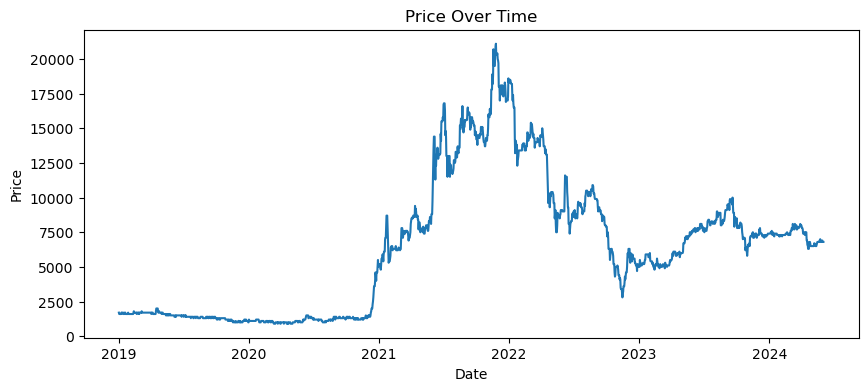

In [76]:
# Assuming you have a DataFrame 'df' with a 'Price' column
plt.figure(figsize=(10, 4))
plt.plot(df_SBS['Price'])
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [77]:
volatily_SBS = 100 * df_SBS.Price.pct_change().dropna()

Text(0.5, 1.0, 'Volatily')

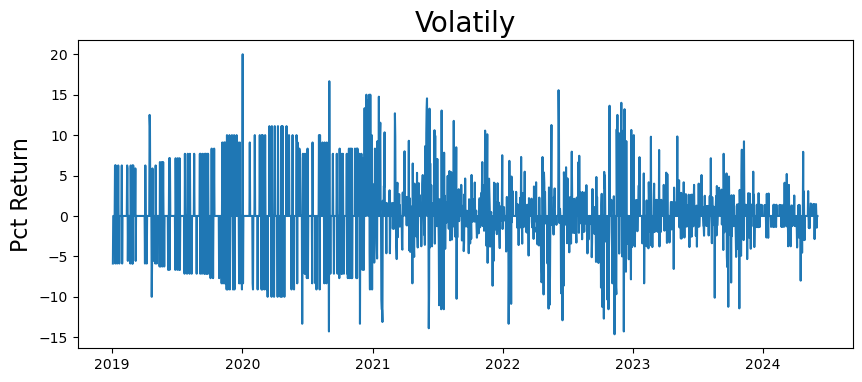

In [78]:
plt.figure(figsize=(10,4))
plt.plot(volatily_SBS)
plt.ylabel('Pct Return', fontsize=16)
plt.title('Volatily', fontsize=20)

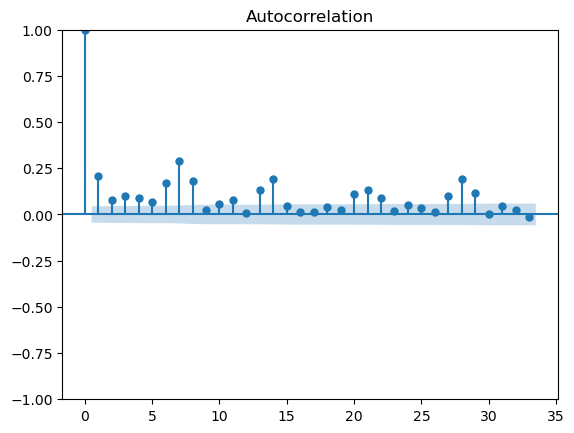

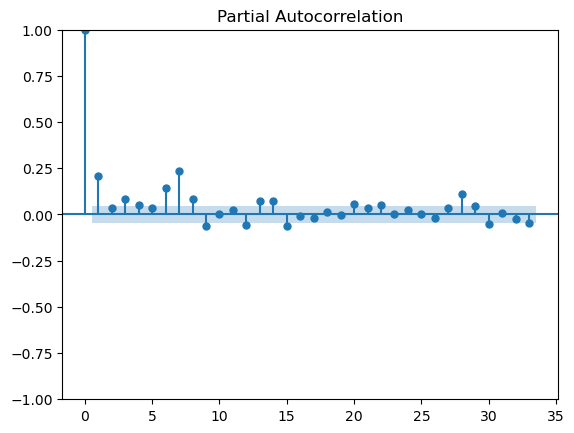

In [79]:
plot_acf(volatily_SBS**2)
plot_pacf(volatily_SBS**2)
plt.show()

In [80]:
model = arch_model(volatily_SBS, p=1, q=1)
model_fit = model.fit()
model_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 13231069099.149773
Iteration:      2,   Func. Count:     14,   Neg. LLF: 9247.30159460257
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8276.546027291664
Iteration:      4,   Func. Count:     29,   Neg. LLF: 5374.234566164505
Iteration:      5,   Func. Count:     35,   Neg. LLF: 5372.974347201507
Iteration:      6,   Func. Count:     41,   Neg. LLF: 5357.406515673878
Iteration:      7,   Func. Count:     47,   Neg. LLF: 5398.7093835484375
Iteration:      8,   Func. Count:     53,   Neg. LLF: 5355.339415423872
Iteration:      9,   Func. Count:     58,   Neg. LLF: 5355.311578147639
Iteration:     10,   Func. Count:     63,   Neg. LLF: 5355.311388252421
Iteration:     11,   Func. Count:     68,   Neg. LLF: 5355.311353062198
Iteration:     12,   Func. Count:     73,   Neg. LLF: 5355.311351532644
Iteration:     13,   Func. Count:     77,   Neg. LLF: 5355.311351532797
Optimization terminated successfully    (Exit mode 0)
         

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5355.31
Distribution:                  Normal   AIC:                           10718.6
Method:            Maximum Likelihood   BIC:                           10741.0
                                        No. Observations:                 1977
Date:                Wed, Jun 05 2024   Df Residuals:                     1976
Time:                        23:45:28   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1012  6.840e-02      1.479      0.139 [-3.288e-02,  0.235]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.1126  6.524e-02      1.726  8.429e-02  [-1.524e-02,  0.240]
alpha[1]       0.0591  1.009e-02      5.856  4.744e-09 [3.930e-02,7.884e-02]
beta[1]        0.9360  1.117e-02     83.786      0.000     [  0.914,  0.958]
============================================================================

Covariance estimator: robust
"""

In [81]:
rolling_predictions_SBS = []  # Danh sách để lưu trữ các dự đoán của mô hình
test_size_SBS = int(0.3 * len(volatily_SBS))  # Xác định kích thước của tập kiểm tra là 30% của độ dài của dữ liệu volatily_SBS

# Vòng lặp for để dự đoán trượt qua từng điểm dữ liệu trong tập kiểm tra
for i in range(test_size_SBS):
    # Tạo tập dữ liệu đào tạo bằng cách cắt từ đầu đến mỗi điểm dữ liệu trong tập kiểm tra
    train_SBS = volatily_SBS[:-(test_size_SBS-i)]
    
    # Tạo mô hình GARCH (1,1) bằng cách sử dụng dữ liệu đào tạo
    model_SBS = arch_model(train_SBS, p=1, q=1)
    
    # Ước lượng mô hình GARCH đã tạo với dữ liệu đào tạo
    model_fit_SBS = model_SBS.fit(disp='off')
    
    # Dự đoán một giai đoạn tiếp theo của biến động (volatility) bằng cách sử dụng hàm forecast() từ mô hình đã ước lượng
    pred_SBS = model_fit_SBS.forecast(horizon=1)
    
    # Thêm giá trị dự đoán cuối cùng của mỗi lượt dự đoán vào danh sách rolling_predictions_SBS
    rolling_predictions_SBS.append(np.sqrt(pred_SBS.variance.values[-1,:][0]))


In [82]:
# Tạo một Series Pandas từ danh sách rolling_predictions, với index được thiết lập là các chỉ mục cuối cùng của tập dữ liệu volatily (tập kiểm tra)
rolling_predictions_SBS = pd.Series(rolling_predictions_SBS, index=volatily_SBS.index[-test_size_SBS:])

In [83]:
from datetime import datetime, timedelta

# Giả định volatily_SBS và test_size_SBS đã được xác định trước đó

def predict_next_days(start_date, days_to_predict, volatily_SBS, test_size_SBS):
    forecasted_next_days_SBS = []
    for i in range(days_to_predict):
        train_SBS = volatily_SBS[:-(test_size_SBS+i)]
        model_SBS = arch_model(train_SBS, p=1, q=1)
        model_fit_SBS = model_SBS.fit(disp='off')
        pred_SBS = model_fit_SBS.forecast(horizon=1)
        forecasted_next_days_SBS.append(np.sqrt(pred_SBS.variance.values[-1,:][0]))

    # Thêm một giá trị không xác định (nan) vào cuối danh sách dự đoán để đại diện cho dự đoán cuối cùng
    forecasted_next_days_SBS.append(np.nan)

    # Tạo ngày bắt đầu dự đoán bằng cách sử dụng start_date được chỉ định
    start_date = start_date

    # Tạo một danh sách chỉ mục mới cho các dự đoán tiếp theo số ngày được chỉ định
    index_forecasted_SBS = pd.date_range(start=start_date, periods=len(forecasted_next_days_SBS))

    return index_forecasted_SBS, forecasted_next_days_SBS

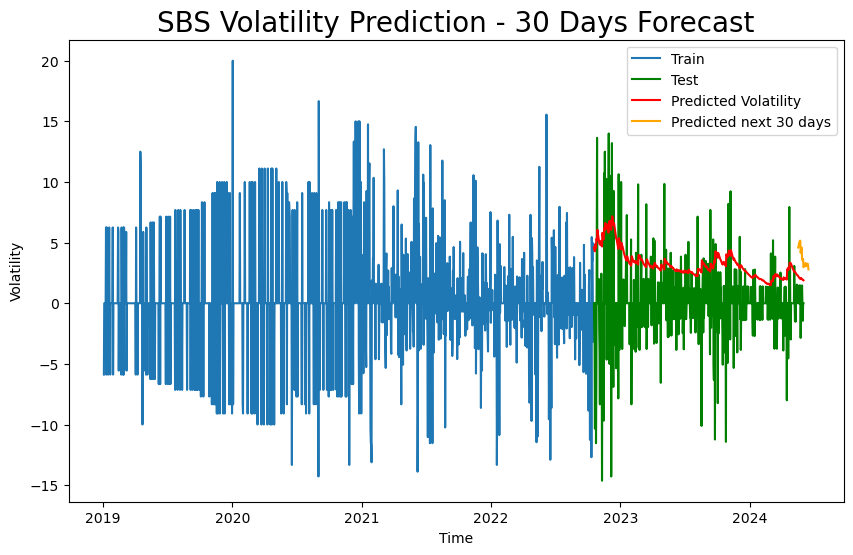

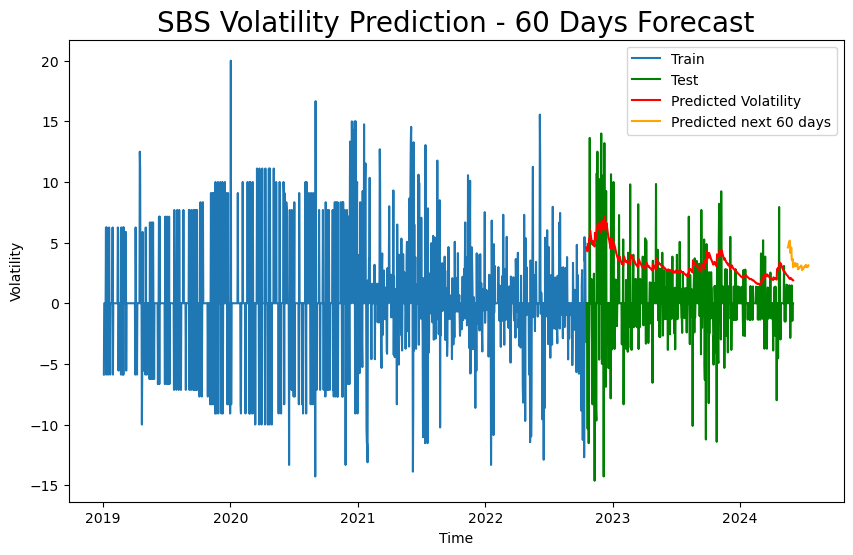

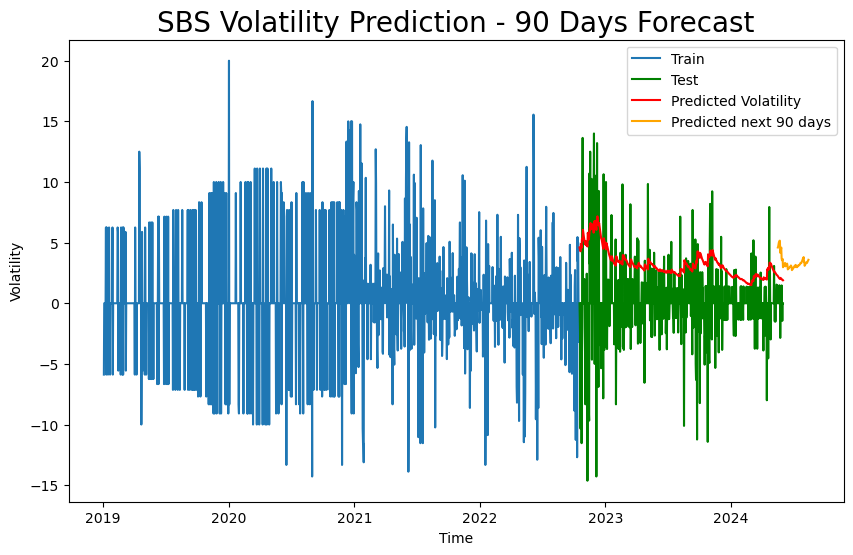

In [84]:
# Đặt số ngày dự đoán
days_to_predict = [30, 60, 90]

# Đặt ngày bắt đầu dự đoán
start_date = pd.Timestamp('2024-05-17')

# Dự đoán cho mỗi số ngày được chỉ định và vẽ biểu đồ tương ứng
for days in days_to_predict:
    index_forecasted_SBS, forecasted_next_days_SBS = predict_next_days(start_date, days, volatily_SBS, test_size_SBS)
    
    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    # Vẽ dữ liệu đào tạo
    plt.plot(volatily_SBS[:-test_size_SBS], label='Train')
    # Vẽ dữ liệu kiểm tra
    plt.plot(volatily_SBS[-test_size_SBS:], label='Test', color='green')
    # Vẽ dự đoán trượt
    plt.plot(rolling_predictions_SBS, label='Predicted Volatility', color='red')
    # Vẽ dự đoán cho số ngày được chỉ định
    plt.plot(index_forecasted_SBS, forecasted_next_days_SBS, label=f'Predicted next {days} days', color='orange')

    # Thêm tiêu đề và chú thích
    plt.title(f'SBS Volatility Prediction - {days} Days Forecast', fontsize=20)
    plt.legend(fontsize=10)
    plt.xlabel('Time')
    plt.ylabel('Volatility')

    # Hiển thị biểu đồ
    plt.show()


In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

test_actual_values_SBS = volatily_SBS[-test_size_SBS:]
test_predicted_values_SBS = rolling_predictions_SBS[volatily_SBS.index[-test_size_SBS:]]

# Calculate MAE_SBS (Mean Absolute Error)
mae_SBS = mean_absolute_error(test_actual_values_SBS, test_predicted_values_SBS)

# Calculate RMSE_SBS (Root Mean Squared Error)
rmse_SBS = np.sqrt(mean_squared_error(test_actual_values_SBS, test_predicted_values_SBS))

# Calculate MAPE_SBS (Mean Absolute Percentage Error)
mape_SBS = np.mean(np.abs((test_actual_values_SBS - test_predicted_values_SBS) / test_actual_values_SBS.replace(0, np.nan))) 

print("MAE_SBS:", mae_SBS)
print("RMSE_SBS:", rmse_SBS)
print("MAPE_SBS (%):", mape_SBS)


MAE_SBS: 3.654463984994378
RMSE_SBS: 4.556539544199196
MAPE_SBS (%): 1.5369194554335432
